In [187]:
import torch
import galsim
import batsim
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.signal import convolve2d

from importlib import reload
reload(batsim)

<module 'batsim' from '/global/u1/c/cmacmah/BATSim/src/batsim/__init__.py'>

9138


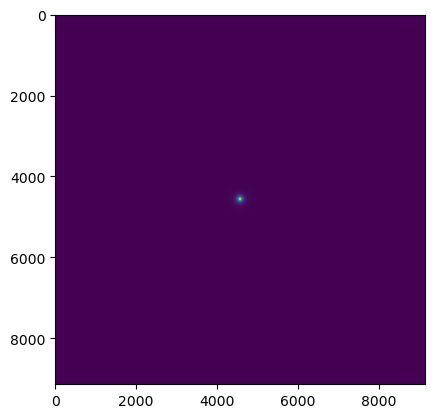

In [188]:
# set galsim parameters
gsparams = galsim.GSParams(maximum_fft_size=2e4, folding_threshold=1e-3)

# create galsim galaxy and psf
galaxy = galsim.Sersic(n=4.5, half_light_radius=1.0, flux=1e5, gsparams=gsparams)

psf = galsim.Moffat(beta=3.5, fwhm=0.8, gsparams=gsparams)

# convolve galaxy with psf
conv = galsim.Convolve([galaxy, psf])

# get required image size and scale to avoid aliasing
nyq = galaxy.nyquist_scale
nn = galaxy.getGoodImageSize(nyq)
print(nn)

# draw GalSim version
gs_conv = conv.shift(0.5*nyq, 0.5*nyq).drawImage(nx=nn, ny=nn, scale=nyq, method='sb').array
gal_no_conv = galaxy.shift(0.5*nyq, 0.5*nyq).drawImage(nx=nn, ny=nn, scale=nyq, method='sb').array
plt.imshow(gs_conv)

In [189]:
# Check GPUs are available
print('CUDA?:', torch.cuda.is_available())
print('# GPUs:', torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

# Set GPU
cuda = torch.device('cuda:0')

CUDA?: True
# GPUs: 4
NVIDIA A100-SXM4-80GB


In [190]:
galstamp = batsim.Stamp(nn=nn, scale=nyq)

coords = galstamp.coords.T
x = coords[:,0].tolist()
y = coords[:,1].tolist()

start = time()
GPUfluxes = batsim._gsinterface.getFluxVecGPU(galaxy._sbp, x, y)
print('GPU time:', time()-start)

start = time()
CPUfluxes = batsim._gsinterface.getFluxVec(galaxy._sbp, x, y)
print('CPU time:', time()-start)

assert GPUfluxes == CPUfluxes

GPU time: 5.077496290206909
CPU time: 3.442004442214966


In [191]:
# Set up BATSim images
galstamp = batsim.Stamp(nn=nn, scale=nyq)
start = time()
gal_im = galstamp.sample_galaxy(galaxy)
print('CPU Time:', time()-start)

# psf might not need as large a stamp
psf_nn = psf.getGoodImageSize(nyq)
psf_stamp = batsim.Stamp(nn=psf_nn, scale=nyq)
psf_im = psf_stamp.sample_galaxy(psf)

def next_power_of_2(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

def calculate_padding(original_size, target_size):
    padding = (target_size - original_size) // 2
    return (padding, padding + (0 if original_size % 2 == 0 else 1))

# Assuming gal_im and psf_im are your image and PSF numpy arrays
gal_im_size = gal_im.shape[0]  # Assuming square images
psf_im_size = psf_im.shape[0]  # Assuming square PSF

# Find the larger dimension and calculate the next power of two
max_size = max(gal_im_size, psf_im_size)
desired_size = next_power_of_2(max_size)

# Calculate padding for both the image and PSF to reach the desired size
gal_padding = calculate_padding(gal_im_size, desired_size)
psf_padding = calculate_padding(psf_im_size, desired_size)
print(gal_padding, psf_padding)

# Apply padding
gal_im_pad = np.pad(gal_im, (gal_padding,), mode='constant')
psf_im_pad = np.pad(psf_im, (psf_padding,), mode='constant')

CPU Time: 12.356772184371948
(3623, 3623) (7911, 7911)


Scipy time: 14.59214162826538


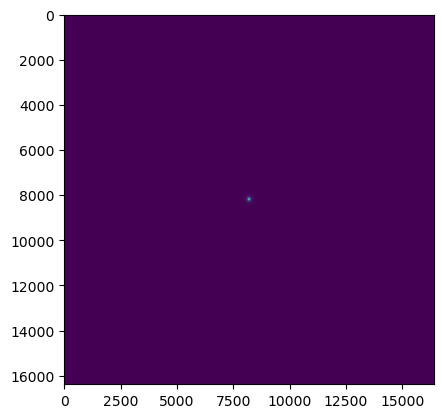

In [192]:
#Benchmark with Scipy
start = time()

# Forward transform
im1_fft = fft2(fftshift(gal_im_pad))
im2_fft = fft2(fftshift(psf_im_pad))

# convolve images 
conv_im_fft = im1_fft * im2_fft

# Backward transform
conv_im_scipy = ifftshift(ifft2(conv_im_fft))

scipy_time = time()-start
print('Scipy time:', scipy_time)

plt.imshow(conv_im_scipy.real)

PyTorch time: 1.664548397064209
PyTorch is 8.766 times faster


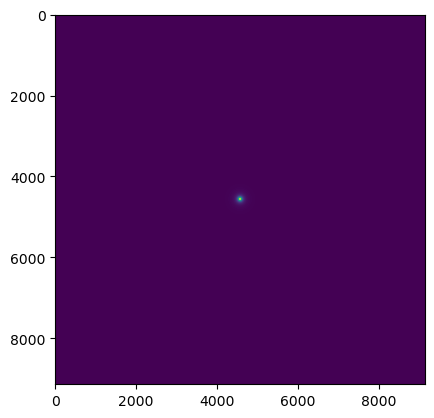

In [200]:
# Now try using pytorch
start = time()

# send data to GPU
torch_im1 = torch.tensor(fftshift(gal_im_pad)).to('cuda')
torch_im2 = torch.tensor(fftshift(psf_im_pad)).to('cuda')

# Forward transform
im1_fft = torch.fft.rfft2(torch_im1)
im2_fft = torch.fft.rfft2(torch_im2)

# Convolve
convolved = im1_fft * im2_fft

# Backward transform
conv_im_torch = torch.fft.irfft2(convolved)
conv_im_torch = ifftshift(conv_im_torch.detach().cpu())

torch_time = time()-start
print('PyTorch time:', torch_time)
print('PyTorch is %1.3f times faster'%(scipy_time/torch_time))
#assert conv_im_torch.all() == conv_im_scipy.all()

# Crop padding from result 
conv_im_torch = conv_im_torch[gal_padding[0]:-gal_padding[0],
                              gal_padding[0]:-gal_padding[0]]
#torch.empty_cache()
torch.cuda.empty_cache()
plt.imshow(conv_im_torch)

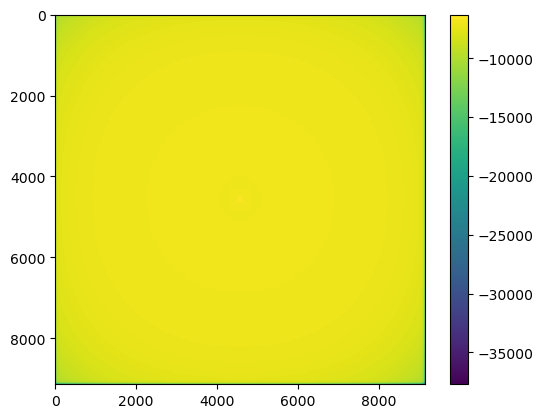

In [194]:
plt.imshow((conv_im_torch - gs_conv)/conv_im_torch)
plt.colorbar()

### Sampling Flux on GPU

IMPORTANT: Need to specify float64, default precision is not high enough to accurately reproduce galsim

In [195]:
galstamp = batsim.Stamp(nn=nn, scale=nyq)

coords = galstamp.coords

# Manually implement calculation of flux for 
# a Sersic profile on the GPU using Pytorch
start = time()
# Initial parameters

r0 = galaxy.scale_radius
inv_r0_sq = (1.0 / r0)**2

n = galaxy.n
inv2n_tens = torch.tensor(1.0 / (2.0 * n), dtype=torch.float64).to('cuda')

gamma2n = np.math.gamma(2.0 * n)
norm = 1. / (2. * np.pi * n * gamma2n)
norm *= galaxy.flux
norm *= inv_r0_sq

# Send to GPU
x_tens = torch.tensor(coords[0], dtype=torch.float64).to('cuda')
y_tens = torch.tensor(coords[1], dtype=torch.float64).to('cuda')
inv_r0_sq_tens = torch.tensor(inv_r0_sq, dtype=torch.float64).to('cuda')

# Perform the calculation
rsq = (x_tens**2 + y_tens**2)*inv_r0_sq_tens
xValue = torch.exp(-torch.pow(rsq, inv2n_tens))
galprof = xValue.detach().cpu().numpy() * norm
galprof = np.reshape(galprof, (nn, nn))
torch_time = time()-start
print('Pytorch GPU runtime:', torch_time)

torch.cuda.empty_cache()

# Benchmark against C++ loop
start = time()
CPUfluxes = batsim._gsinterface.getFluxVec(galaxy._sbp, x, y)
CPUfluxes = np.reshape(CPUfluxes, (nn, nn))
cpp_time = time()-start
print('C++ CPU runtime:', cpp_time)

print('Speedup:', cpp_time/torch_time)

Pytorch GPU runtime: 0.33508872985839844
C++ CPU runtime: 8.618240118026733
Speedup: 25.719277761650247
C++ CPU runtime: 8.618240118026733
Speedup: 25.719277761650247


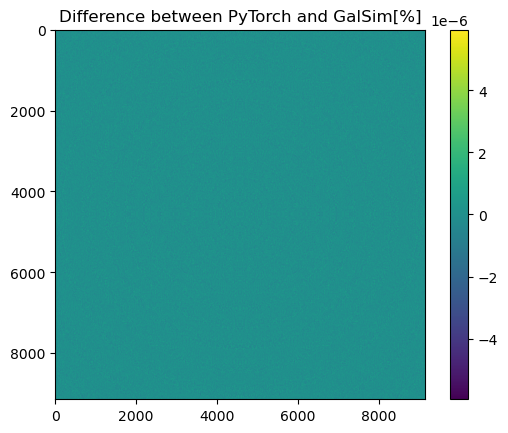

In [196]:
plt.title('Difference between PyTorch and GalSim[%]')
plt.imshow(((galprof-gal_no_conv)/galprof) * 100)
plt.colorbar()

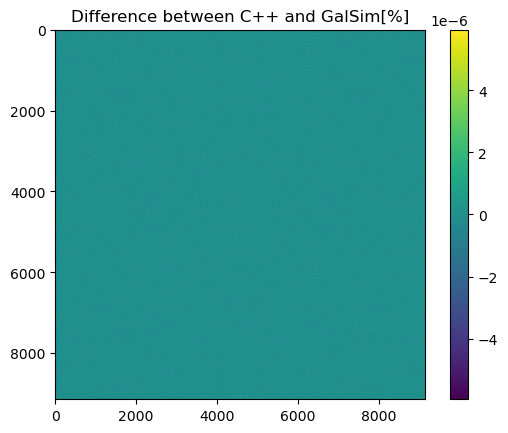

In [197]:
plt.title('Difference between C++ and GalSim[%]')
plt.imshow(((CPUfluxes-gal_no_conv)/CPUfluxes) * 100)
plt.colorbar()

In [198]:
start = time()
gs_test = galaxy.drawImage(nx=nn, ny=nn, scale=nyq, method='no_pixel').array
gs_time = time()-start
print('GalSim time:', gs_time)

start = time()
CPUfluxes = batsim._gsinterface.getFluxVec(galaxy._sbp, x, y)
CPUfluxes = np.reshape(CPUfluxes, (nn, nn))
cpp_time = time()-start
print('CPU time:', cpp_time)

GalSim time: 1.499328374862671
CPU time: 8.124070167541504
CPU time: 8.124070167541504
